# 02 - Preprocesamiento y Visualización de Vulnerabilidades
Este notebook carga el archivo CSV generado por la API del NIST, realiza limpieza y preprocesamiento, y genera visualizaciones para comprender los datos.

## Importacion de librerias y carga del archivo CSV creado

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivo CSV exportado en el notebook anterior
df = pd.read_csv("vulnerabilidades_2024.csv")
df.head()

,cve_id,published,last_modified,source_identifier,description,severity,cvss_score,vector,exploitability_score,impact_score
0,CVE-1999-0241,1995-11-01T05:00:00.000,2024-11-20T23:28:13.143,cve@mitre.org,guessable magic cookies in x windows allows re...,HIGH,10.0,AV:N/AC:L/Au:N/C:C/I:C/A:C,10.0,10.0
1,CVE-1999-0179,1997-01-01T05:00:00.000,2024-11-20T23:28:03.757,cve@mitre.org,windows nt crashes or locks up when a samba cl...,MEDIUM,5.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,10.0,2.9
2,CVE-1999-0249,1997-01-01T05:00:00.000,2024-11-20T23:28:14.380,cve@mitre.org,windows nt rshsvc program allows remote users ...,HIGH,7.2,AV:L/AC:L/Au:N/C:C/I:C/A:C,3.9,10.0
3,CVE-1999-0274,1997-01-01T05:00:00.000,2024-11-20T23:28:18.163,cve@mitre.org,denial of service in windows nt dns servers th...,MEDIUM,5.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,10.0,2.9
4,CVE-1999-0345,1997-01-01T05:00:00.000,2024-11-20T23:28:28.900,cve@mitre.org,jolt icmp attack causes a denial of service in...,MEDIUM,5.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,10.0,2.9


## Limpieza de datos

In [6]:
# Conversión de fechas
df["published"] = pd.to_datetime(df["published"], errors="coerce")
df["last_modified"] = pd.to_datetime(df["last_modified"], errors="coerce")

# Limpiar valores nulos
df["description"] = df["description"].fillna("Sin descripción")
df["severity"] = df["severity"].fillna("unknown").str.lower()
df["cvss_score"] = pd.to_numeric(df["cvss_score"], errors="coerce")
df["exploitability_score"] = pd.to_numeric(df["exploitability_score"], errors="coerce")
df["impact_score"] = pd.to_numeric(df["impact_score"], errors="coerce")

# Filtrar registros con severidad desconocida
df = df[df["severity"] != "unknown"]

# Crear columnas adicionales
df["month"] = df["published"].dt.to_period("M")
df["year"] = df["published"].dt.year

## Datos tratados para ser enviados a la base de datos

In [7]:
df.to_csv("tratados.csv", index=False, encoding="utf-8")

Verificamos lo que emos creado

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3793 entries, 0 to 3926
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cve_id                3793 non-null   object        
 1   published             3793 non-null   datetime64[ns]
 2   last_modified         3793 non-null   datetime64[ns]
 3   source_identifier     3793 non-null   object        
 4   description           3793 non-null   object        
 5   severity              3793 non-null   object        
 6   cvss_score            3793 non-null   float64       
 7   vector                3793 non-null   object        
 8   exploitability_score  3793 non-null   float64       
 9   impact_score          3793 non-null   float64       
 10  month                 3793 non-null   period[M]     
 11  year                  3793 non-null   int32         
dtypes: datetime64[ns](2), float64(3), int32(1), object(5), period[M](1)
memory usage:

# Gráficos de la informacion obtenida

## Gráfico: Severidad 

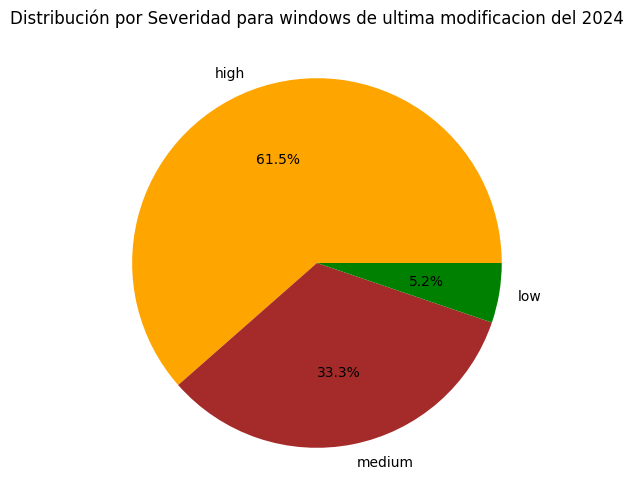

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
severity_counts = df["severity"].value_counts()
colors = {'low': 'green', 'medium': 'brown', 'high': 'orange', 'critical': 'red'}
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%',
        colors=[colors.get(s, 'gray') for s in severity_counts.index])
plt.title("Distribución por Severidad para windows de ultima modificacion del 2024")
plt.show()


## 2. Gráfico: Vulnerabilidades por años

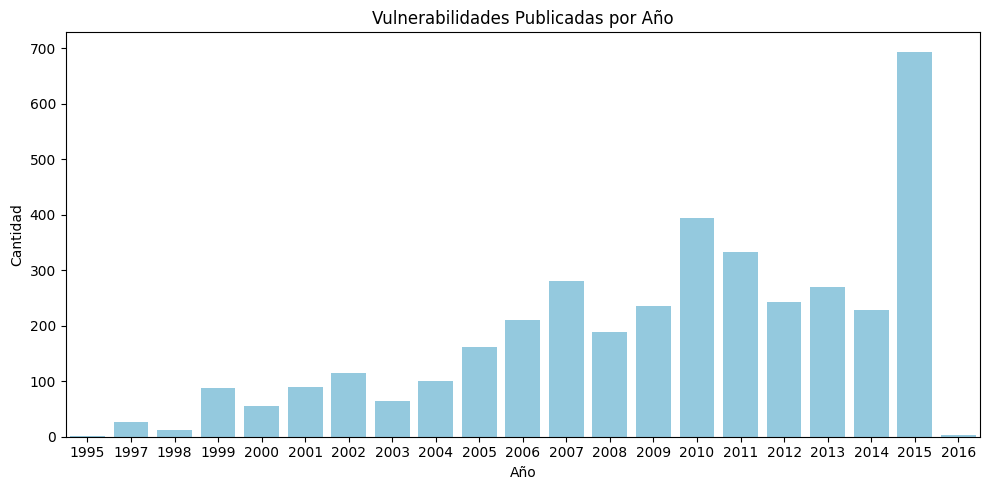

In [18]:
vulns_por_ano = df['year'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=vulns_por_ano.index, y=vulns_por_ano.values, color="skyblue")
plt.title("Vulnerabilidades Publicadas por Año")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


## 3.Gráfico: Vulnerabilidades por Año y Severidad (gráfico agrupado)

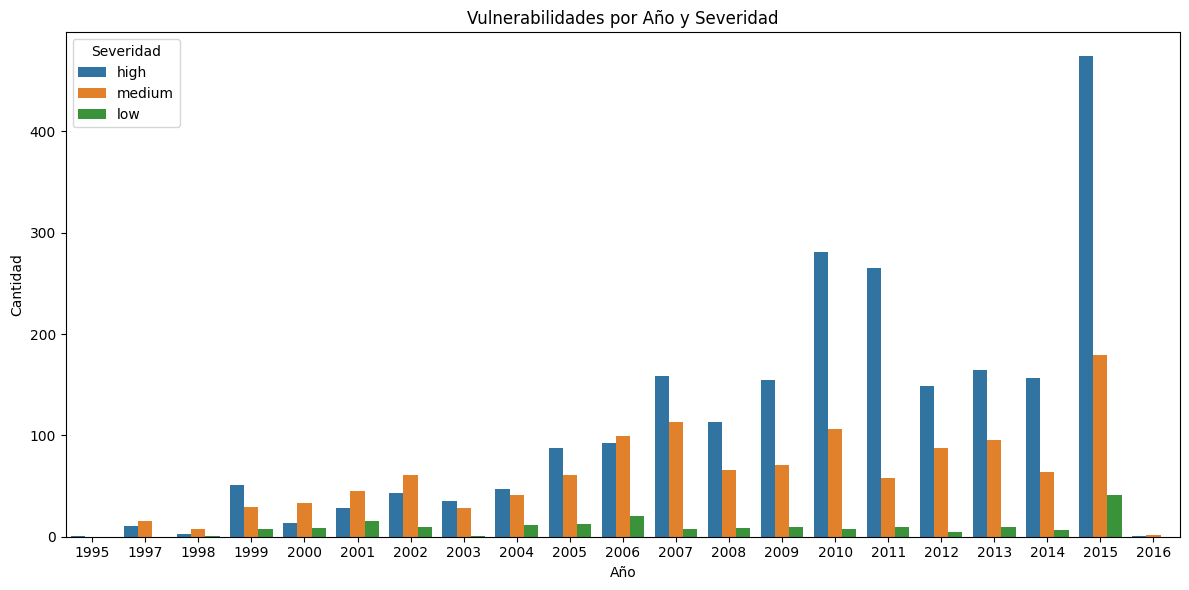

In [19]:
plt.figure(figsize=(12, 6))

# Agrupar por año y severidad
vulns_grouped = df.groupby(["year", "severity"]).size().reset_index(name="cantidad")

# Gráfico agrupado por 'year' y 'severity'
sns.barplot(data=vulns_grouped, x="year", y="cantidad", hue="severity")

plt.title("Vulnerabilidades por Año y Severidad")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.legend(title="Severidad")
plt.tight_layout()
plt.show()


## 4.Gráfico: CVSS Score promedio por año

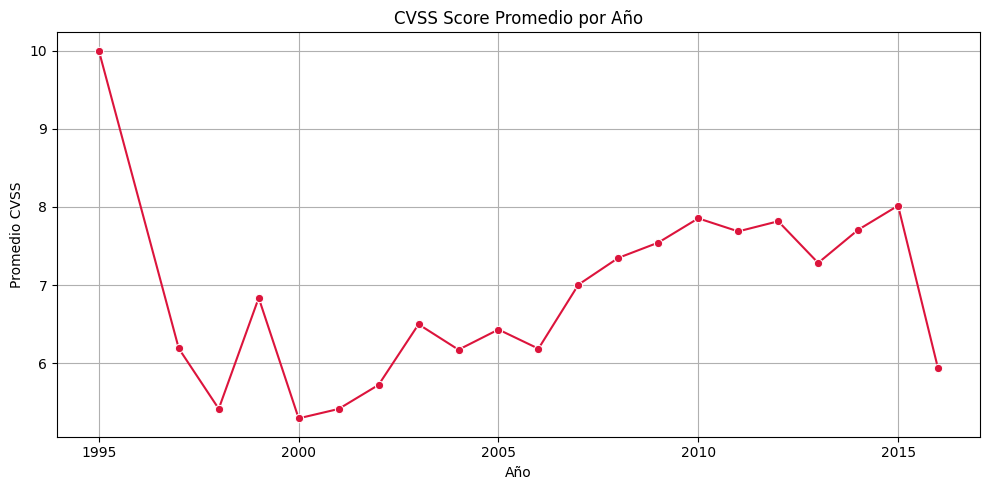

In [20]:
plt.figure(figsize=(10, 5))

# Agrupar y calcular el promedio de CVSS por año
cvss_por_ano = df.groupby("year")["cvss_score"].mean().dropna()

# Gráfico de línea
sns.lineplot(x=cvss_por_ano.index, y=cvss_por_ano.values, marker="o", color="crimson")

plt.title("CVSS Score Promedio por Año")
plt.xlabel("Año")
plt.ylabel("Promedio CVSS")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretacion del grafo 4:
El hecho de que CVEs antiguas estén siendo modificadas en 2024 muestra la persistencia o revisión continua de riesgos pasados en sistemas Windows.

## 5.Gráfico: CVEs con impact_score == 10 agrupados por año y severidad

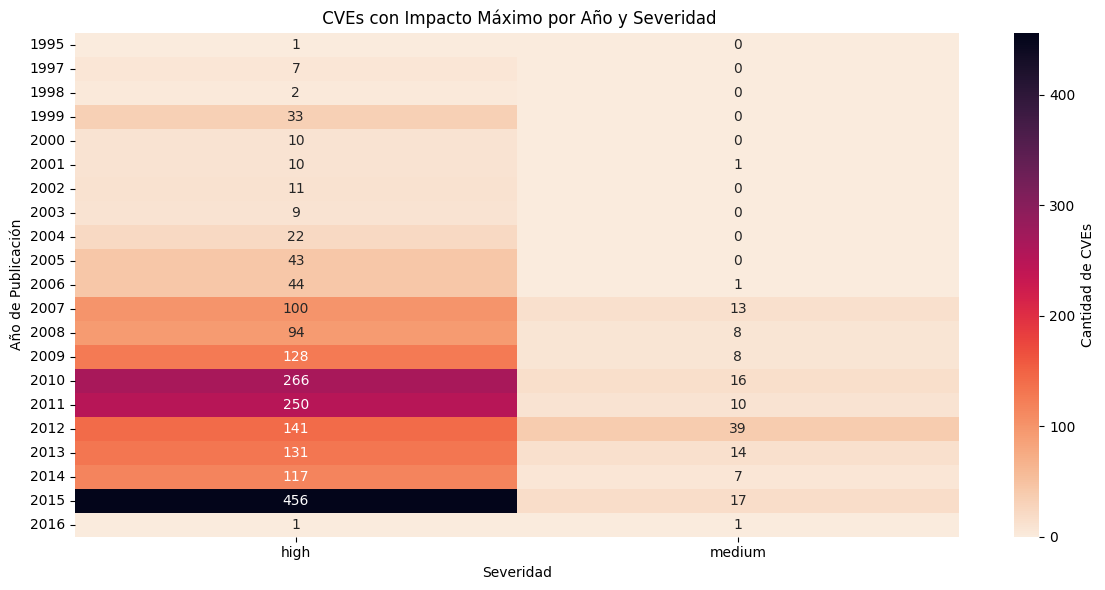

In [21]:
# Filtrar solo CVEs con impacto crítico
criticos = df[df["impact_score"] == 10]

# Crear tabla año (published) vs severidad
tabla_criticos = pd.crosstab(criticos["published"].dt.year, criticos["severity"])

# Mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_criticos, cmap="rocket_r", annot=True, fmt="d", cbar_kws={'label': 'Cantidad de CVEs'})

plt.title(" CVEs con Impacto Máximo por Año y Severidad")
plt.xlabel("Severidad")
plt.ylabel("Año de Publicación")
plt.tight_layout()
plt.show()
